In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
data_path = 'rct.csv'

df = pd.read_csv(data_path)

In [30]:
df.head()

,grade,label,rct,tsi,stfi,caliper,moisture,basisweight,cull
0,NL050550,4/16/2017 2:36,123.0,4.88,NaN,15.56,0.00,0.0,119.5
1,NL050550,4/16/2017 4:09,127.0,5.15,NaN,15.56,0.00,0.0,119.5
2,NL250740,1/7/2017 15:55,151.0,4.53,NaN,19.24,0.00,0.0,149.5
3,NL110550,2/19/2017 16:20,121.0,4.53,18.1,9.38,6.21,0.0,119.5
4,NL050550,4/16/2017 0:59,123.0,#DIV/0!,NaN,15.67,#DIV/0!,0.0,119.5


In [31]:
# drops weird moisture values
df = df[df.moisture.str.contains('#DIV/0!') == False]
# drops empty and 0 value rows
df = df[np.isfinite(df['stfi'])]

In [32]:
df.head()

,grade,label,rct,tsi,stfi,caliper,moisture,basisweight,cull
3,NL110550,2/19/2017 16:20,121.0,4.53,18.10,9.38,6.21,0.00,119.5
7,NL050550,1/19/2017 14:27,122.0,4.06,19.15,10.82,7.06,26.16,119.5
8,NL050350,1/3/2017 12:40,76.0,4.56,19.81,10.60,6.74,34.89,69.5
9,NL050350,1/3/2017 10:48,74.0,4.60,19.30,10.64,7.14,35.26,69.5
10,NL050350,1/3/2017 14:32,77.0,4.63,20.11,10.53,7.04,35.28,69.5


In [33]:
df['tsi'] = df['tsi'].astype(float)
df['moisture'] = df['moisture'].astype(float)

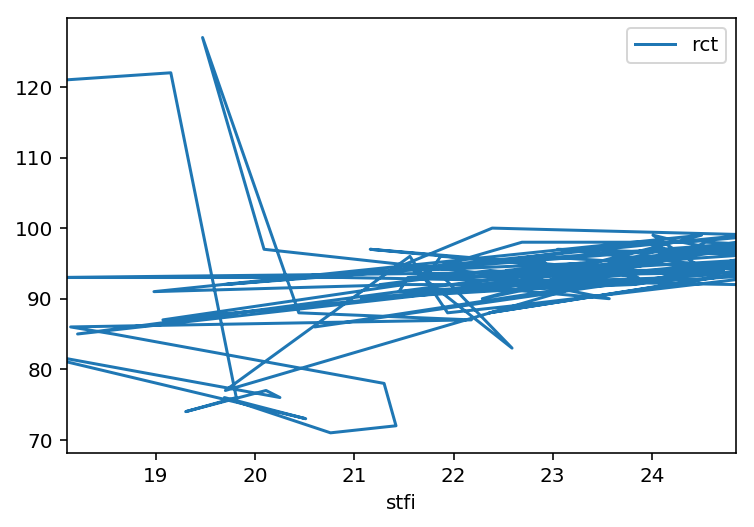

In [34]:
df[:100].plot(x='stfi', y='rct')

In [35]:
# make binary numbers for grades
dummy_fields = ['grade']
for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
    
fields_to_drop = ['label', 'grade']
data = df.drop(fields_to_drop, axis=1)
data.head()

,rct,tsi,stfi,caliper,moisture,basisweight,cull,grade_NL050350,grade_NL050420,grade_NL050550,grade_NL050740,grade_NL110550,grade_NL110740,grade_NL110850,grade_NL250550,grade_NL250740,grade_NL550740
3,121.0,4.53,18.10,9.38,6.21,0.00,119.5,0,0,0,0,1,0,0,0,0,0
7,122.0,4.06,19.15,10.82,7.06,26.16,119.5,0,0,1,0,0,0,0,0,0,0
8,76.0,4.56,19.81,10.60,6.74,34.89,69.5,1,0,0,0,0,0,0,0,0,0
9,74.0,4.60,19.30,10.64,7.14,35.26,69.5,1,0,0,0,0,0,0,0,0,0
10,77.0,4.63,20.11,10.53,7.04,35.28,69.5,1,0,0,0,0,0,0,0,0,0


In [36]:

quant_features = ['rct','tsi', 'stfi','caliper','moisture','basisweight','cull']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = (data[each]).mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
data.head()

,rct,tsi,stfi,caliper,moisture,basisweight,cull,grade_NL050350,grade_NL050420,grade_NL050550,grade_NL050740,grade_NL110550,grade_NL110740,grade_NL110850,grade_NL250550,grade_NL250740,grade_NL550740
3,-0.408414,-0.847915,-2.318256,-2.536936,-0.419331,-5.673515,-0.220737,0,0,0,0,1,0,0,0,0,0
7,-0.358274,-2.567359,-2.099481,-2.001165,1.284747,-3.042524,-0.220737,0,0,1,0,0,0,0,0,0,0
8,-2.664719,-0.738164,-1.961965,-2.083019,0.643212,-2.164521,-2.851408,1,0,0,0,0,0,0,0,0,0
9,-2.764999,-0.591828,-2.068227,-2.068136,1.445131,-2.127309,-2.851408,1,0,0,0,0,0,0,0,0,0
10,-2.614579,-0.482076,-1.899458,-2.109063,1.244651,-2.125298,-2.851408,1,0,0,0,0,0,0,0,0,0


In [37]:

test_data = data[1000:]

data = data[:1000]

target_fields = ['rct']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [38]:

train_features, train_targets = features[:900], targets[:900]
val_features, val_targets = features[900:], targets[900:]
#features.head()

In [39]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1/(1 + np.exp(-x))   # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X,self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
            
            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer'this
            '''
            print('X: ' + str(X))
            print('y: '+ str(y))
            print('weights in to hidden: ' + str(self.weights_input_to_hidden))
            print('hidden input: '+ str(hidden_inputs))
            print('hidden outputs: ' + str(hidden_outputs))
            print('weights hidden to out: ' + str(self.weights_hidden_to_output))
            print('final inputs: ' + str(final_inputs))
            print('final outputs: ' + str(final_outputs)) '''
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            '''print('error: ' + str(error))'''
            
            
            output_error_term = error * 1
            #print('output error term: ' + str(output_error_term))
            # TODO: Calculate the hidden layer's contribution to the error
            

            # TODO: Backpropagated error terms - Replace these values with your calculations.
            #hidden_error = hidden_outputs * (1 - hidden_outputs)
            #hidden_error_term = np.dot(hidden_error, self.weights_hidden_to_output) * output_error_term
            hidden_error = np.dot(self.weights_hidden_to_output, error)
            hidden_error_term = hidden_error * hidden_outputs * (1- hidden_outputs)
            #print('hidden error term: ' + str(hidden_error_term))
            
            
            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:,None]
            #print('delta in to hidden: ' + str(delta_weights_i_h))
            
            
            # Weight step (hidden to output)
            hidden_outputs = hidden_outputs[:,None]
            delta_weights_h_o += output_error_term * hidden_outputs
            #print('delta hidden to out: ' + str(delta_weights_h_o))

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o/n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h/n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features,self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
        final_outputs = (final_inputs) # signals from final output layer 
        
        return final_outputs

In [40]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [87]:
import sys

### Set the hyperparameters here ###
iterations = 2000
learning_rate = 0.001
hidden_nodes = 3200
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['rct']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['rct'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['rct'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.048 ... Validation loss: 0.055

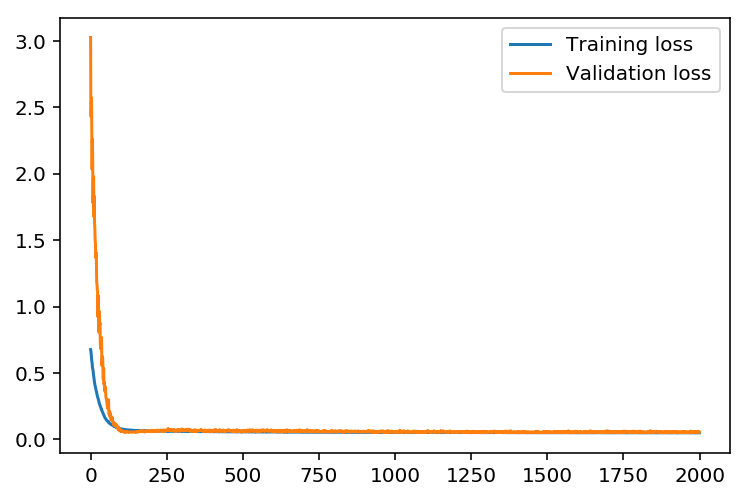

In [88]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

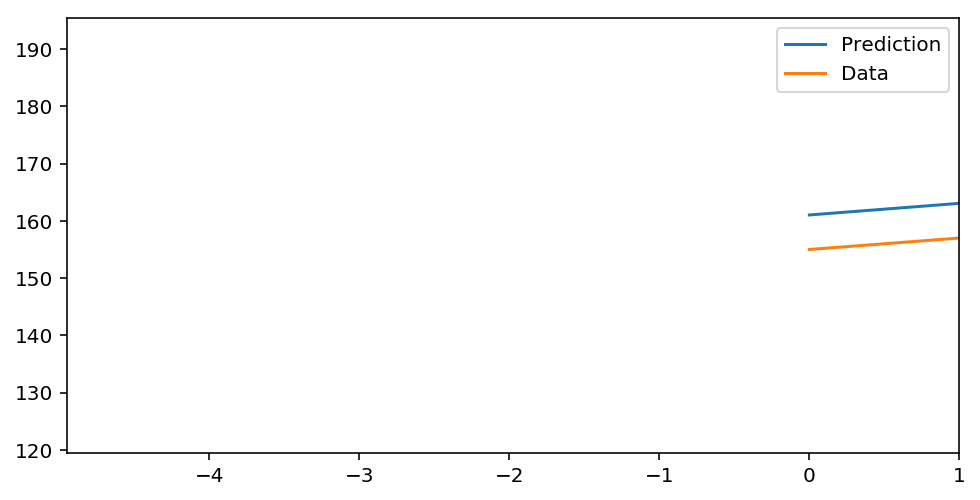

In [89]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['rct']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['rct']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

#dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
#dates = dates.apply(lambda d: d.strftime('%b %d'))
#ax.set_xticks(np.arange(len(dates))[12::24])
#_ = ax.set_xticklabels(dates[12::24], rotation=45)

In [90]:
print(network.weights_hidden_to_output)
#print(network.weights_input_to_hidden)

[[-0.00733339]
 [ 0.00711638]
 [ 0.01144142]
 ..., 
 [ 0.01124162]
 [ 0.00158796]
 [-0.03444768]]


In [91]:
#predictions = network.run(test_features).T*std + mean
#print(predictions)

In [92]:
mean, std = scaled_features['rct']
xs = []
ys = []
value = []
testfeatures = features.reset_index(drop=True)
testTargets = targets.reset_index(drop=True)

for index, row in features.iterrows():
    prediction = network.run(row).T*std+mean
    xs.append(prediction)
    #print(target)

ys = testTargets['rct'].T*std+mean

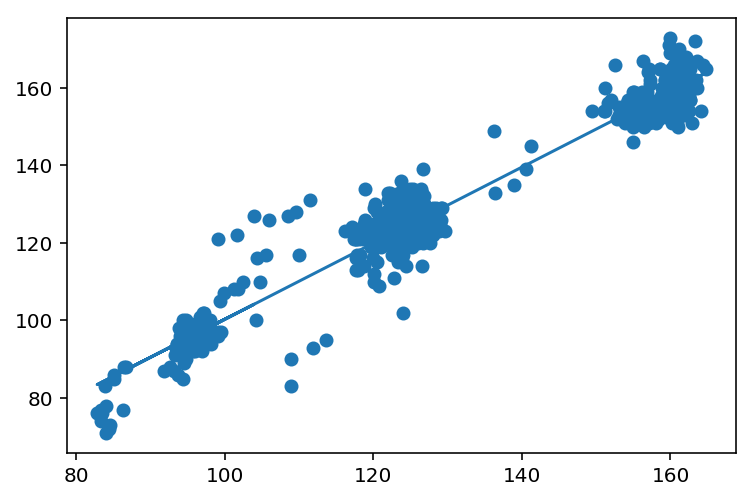

r squared value:
0.941925364602


In [93]:
from sklearn import linear_model
#train model on data
body_reg = linear_model.LinearRegression()
body_reg.fit(xs, ys)

#visualize results
plt.scatter(xs, ys)
plt.plot(xs, body_reg.predict(xs))
plt.show()
print('r squared value:')
print(body_reg.score(xs,ys))
    
    